# Library

In [ ]:
!pip install langdetect

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import nltk
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')
from nltk import sent_tokenize, word_tokenize
#from nltk.stem.snowball import SnowballStemmer
#from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import re  
import pandas as pd 
from langdetect import detect, DetectorFactory  # "pip install langdetect" if cannot find

In [ ]:
#Import all the dependencies
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from keras.utils import np_utils

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split # Import train_test_split function
#from keras import layers, models, optimizers
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

# Read data

In [ ]:
from google.colab import auth
auth.authenticate_user()

from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from oauth2client.client import GoogleCredentials
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1XvqYk-ZjdSm-slfAcsYMsBFhgN1c-ZWC/view?usp=sharing' # The shareable link
  
# to get the id part of the file 
id = link.split("/")[-2]

myfile = drive.CreateFile({'id':id})
myfile.GetContentFile('webtext_gpt2_cleaned.csv')

In [ ]:
df = pd.read_csv('webtext_gpt2_cleaned.csv', index_col=0)
print(df.shape)
df

(99983, 7)


,id,ended,length,text,type,label,tidy_text
0,47018,True,102,The overarching quality of the Bloomberg era w...,train,real,overarching quality Bloomberg era change marry...
1,94338,True,142,This is about as bad as my morning commute get...,train,real,bad morning commute get winter long minute wai...
2,44507,True,631,More on Saskatchewan Liquor Privatization\n\nM...,train,real,Saskatchewan Liquor Privatization late planet ...
3,163493,False,1024,Killen was here\n\nPatrick Killen helped defin...,train,real,Killen Patrick Killen help define modern archi...
4,91925,True,51,Mailbox Rental & Mail Forwarding\n\nServices i...,train,real,Mailbox Rental Mail Forwarding Services Delawa...
...,...,...,...,...,...,...,...
99978,88658,True,548,The official website for Donten ni Warau TV 's...,train,GPT-2,official website Donten ni Warau TV Maken ki t...
99979,7575,True,803,"I have a long, slow, and somewhat unproductive...",train,GPT-2,long slow somewhat unproductive relationship G...
99980,38428,False,1024,"""Flexibility Is Not an Option""\n\nAt The Nouri...",train,GPT-2,flexibility option Nourish School use plant ba...
99981,129005,True,137,\nDuck Dynasty's Phil Robertson will have to m...,train,GPT-2,Duck Dynasty Phil Robertson make due reality t...


In [ ]:
cols = ['length', 'text', 'label', 'tidy_text']
df[cols]

,length,text,label,tidy_text
0,102,The overarching quality of the Bloomberg era w...,real,overarching quality Bloomberg era change marry...
1,142,This is about as bad as my morning commute get...,real,bad morning commute get winter long minute wai...
2,631,More on Saskatchewan Liquor Privatization\n\nM...,real,Saskatchewan Liquor Privatization late planet ...
3,1024,Killen was here\n\nPatrick Killen helped defin...,real,Killen Patrick Killen help define modern archi...
4,51,Mailbox Rental & Mail Forwarding\n\nServices i...,real,Mailbox Rental Mail Forwarding Services Delawa...
...,...,...,...,...
99978,548,The official website for Donten ni Warau TV 's...,GPT-2,official website Donten ni Warau TV Maken ki t...
99979,803,"I have a long, slow, and somewhat unproductive...",GPT-2,long slow somewhat unproductive relationship G...
99980,1024,"""Flexibility Is Not an Option""\n\nAt The Nouri...",GPT-2,flexibility option Nourish School use plant ba...
99981,137,\nDuck Dynasty's Phil Robertson will have to m...,GPT-2,Duck Dynasty Phil Robertson make due reality t...


In [ ]:
# Shuffel the dataframe

df = shuffle(df).reset_index(drop=True)
df

,id,ended,length,text,type,label,tidy_text
0,193680,True,1017,What happens if you try to get a gun without a...,train,GPT-2,happen try get gun without background check tu...
1,124763,True,90,"""Jim: On Kenya, your person in the field might...",train,real,Jim Kenya person field may look impact Obama p...
2,80563,True,155,The latest offering from Corporate Watch is no...,train,real,late offering Corporate Watch available buy Fr...
3,37623,True,411,Mumbai has one of the largest number of migran...,train,real,Mumbai one large number migrant India accord U...
4,8716,True,87,Make sure to check out the Tournament Informat...,train,real,make sure check Tournament Information rule ev...
...,...,...,...,...,...,...,...
99978,194673,True,89,Guido is a given name Latinised from the Old H...,train,real,Guido give name latinise old high german name ...
99979,26062,True,48,50 rows before articulations.\n\n6 rows betwee...,train,real,row articulation row articulation row articula...
99980,113854,True,990,Dating and Relationships is a difficult and em...,train,GPT-2,date Relationships difficult emotional journey...
99981,20945,True,413,There has been a huge surge in the production ...,train,GPT-2,huge surge production sale porn since accord N...


In [ ]:
df['token_words'] = df['tidy_text'].apply(lambda x: x.split())
df

,id,ended,length,text,type,label,tidy_text,token_words
0,193680,True,1017,What happens if you try to get a gun without a...,train,GPT-2,happen try get gun without background check tu...,"[happen, try, get, gun, without, background, c..."
1,124763,True,90,"""Jim: On Kenya, your person in the field might...",train,real,Jim Kenya person field may look impact Obama p...,"[Jim, Kenya, person, field, may, look, impact,..."
2,80563,True,155,The latest offering from Corporate Watch is no...,train,real,late offering Corporate Watch available buy Fr...,"[late, offering, Corporate, Watch, available, ..."
3,37623,True,411,Mumbai has one of the largest number of migran...,train,real,Mumbai one large number migrant India accord U...,"[Mumbai, one, large, number, migrant, India, a..."
4,8716,True,87,Make sure to check out the Tournament Informat...,train,real,make sure check Tournament Information rule ev...,"[make, sure, check, Tournament, Information, r..."
...,...,...,...,...,...,...,...,...
99978,194673,True,89,Guido is a given name Latinised from the Old H...,train,real,Guido give name latinise old high german name ...,"[Guido, give, name, latinise, old, high, germa..."
99979,26062,True,48,50 rows before articulations.\n\n6 rows betwee...,train,real,row articulation row articulation row articula...,"[row, articulation, row, articulation, row, ar..."
99980,113854,True,990,Dating and Relationships is a difficult and em...,train,GPT-2,date Relationships difficult emotional journey...,"[date, Relationships, difficult, emotional, jo..."
99981,20945,True,413,There has been a huge surge in the production ...,train,GPT-2,huge surge production sale porn since accord N...,"[huge, surge, production, sale, porn, since, a..."


# Cross validation by splitting data into train and test set

Cross validation by splitting the data into training set (80%) and testing set (20%)

In [ ]:
# Split the data into training set (80%) and test set (20%)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=1)

In [ ]:
print(len(train_data))
print(len(test_data))

79986
19997


In [ ]:
train_data

,id,ended,length,text,type,label,tidy_text,token_words
69597,6288,True,622,"""My parents said the first thing I should do w...",train,GPT-2,parent say first thing get job case get job re...,"[parent, say, first, thing, get, job, case, ge..."
29120,135054,True,366,"In 2011, a new generation of home video games ...",train,GPT-2,new generation home video game go development ...,"[new, generation, home, video, game, go, devel..."
65049,252063,False,1024,by\n\nIf I see a major magazine or blog publis...,valid,real,see major magazine blog publish another Best a...,"[see, major, magazine, blog, publish, another,..."
65901,248098,False,1024,Self-styled film critic Kamaal R Khan on Sunda...,train,real,self style film critic Kamaal Khan Sunday laun...,"[self, style, film, critic, Kamaal, Khan, Sund..."
29099,66283,True,426,Japan's Agency for Cultural Affairs announced ...,train,real,Japan Agency Cultural Affairs announce winner ...,"[Japan, Agency, Cultural, Affairs, announce, w..."
...,...,...,...,...,...,...,...,...
50057,110816,True,78,Search for one of our more than 650 physicians...,train,real,search one physician make appointment find dir...,"[search, one, physician, make, appointment, fi..."
98047,68213,True,785,As the U.S. Senate floor was clearing out for ...,train,real,Senate floor clear lunch Wednesday vote advanc...,"[Senate, floor, clear, lunch, Wednesday, vote,..."
5192,213669,False,1024,How a little-known 'black box' of information ...,train,GPT-2,little know black box information find way pub...,"[little, know, black, box, information, find, ..."
77708,178775,True,739,Friends say Ibrahim Abukar had the charisma an...,train,real,friend say Ibrahim Abukar charisma business ta...,"[friend, say, Ibrahim, Abukar, charisma, busin..."


Summary of label frequency:
GPT-2    40072
real     39914
Name: label, dtype: int64



Text(0, 0.5, 'Frequency')

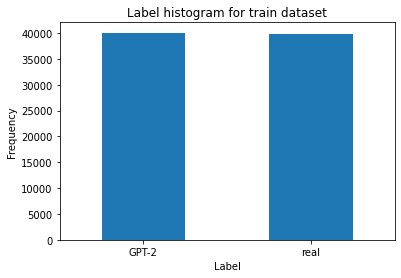

In [ ]:
# For train data

# Summary of label frequency
print("Summary of label frequency:")
print(train_data['label'].value_counts())
print()

# Plot the frequency of LABEL 
pd.value_counts(train_data['label']).plot.bar(rot=0) # rot=0 for rotate the values of x-axis
#or df.plot.bar(rot=0) # or df.T.plot.bar(rot=0)
plt.title('Label histogram for train dataset')
plt.xlabel('Label')
plt.ylabel('Frequency')

Summary of label frequency:
real     10083
GPT-2     9914
Name: label, dtype: int64



Text(0, 0.5, 'Frequency')

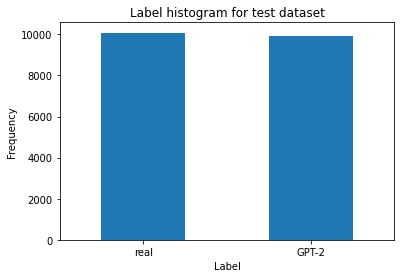

In [ ]:
# For test data

# Summary of test frequency
print("Summary of label frequency:")
print(test_data['label'].value_counts())
print()

# Plot the frequency of LABEL 
pd.value_counts(test_data['label']).plot.bar(rot=0) # rot=0 for rotate the values of x-axis
#or df.plot.bar(rot=0) # or df.T.plot.bar(rot=0)
plt.title('Label histogram for test dataset')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Difference between PV-DM and PV-DBOW in Doc2vec

In Doc2vec, by default dm=1 (PV-DM) and if dm=0 then PV-DBOW.

The first method is the **PV-DM (paragraph vector: distributed memory)**. This samples a fixed-length (say, 3) from the context window. Each of the 3-words is represented by a 7-dimension vector. The paragraph vector is also represented by a 7-dimension vector. The 4 (3+1) vectors are concatenated (into a 28-dimensional vector) or averaged (into a 7-dimensional vector) to be used as input to predict for the next word. The concatenation of word vectors in a small context window takes into consideration the word order.


The second method is the **PV-DBOW (paragraph vector: distributed bag of words)**. This randomly samples 4 words from the paragraph, and only uses the paragraph vector as input.


Ref: https://joshuakyh.wordpress.com/2017/12/07/distributed-representation-of-anything/#:~:text=Differences%3A,word%20vectors%20in%20PV%2DDM.

To paraphrase Google's [documentation](https://www.tensorflow.org/tutorials/text/word2vec): The CBOW/DBOW model predicts the target word from a bag of context words (e.g. "mat" from "the cat sits on the") while the DM model predicts a skip-gram from a single word (e.g. "sits .. mat" from "cat").


Ref: https://datascience.stackexchange.com/questions/26528/full-doc2vec-implementation-repdoduction-in-tensorflow

Differences:

- PV-DM predicts 1 word from 4 inputs; PV-DBOW predicts 4 words from 1 input.
- PV-DM draws words from the surrounding words of the target word; PV-DBOW draws words from the paragraph.
- PV-DBOW stores less data – only the softmax weights are stored, as opposed to both softmax weights and word vectors in PV-DM.



Ref: https://joshuakyh.wordpress.com/2017/12/07/distributed-representation-of-anything/#:~:text=Differences%3A,word%20vectors%20in%20PV%2DDM. 

# Doc2Vec with PV-DM + Prediction Models

## Doc2Vec (PV_DM) representative

- dm: Decides which algorithm out of PV-DM and PV-DBOW. By default dm=1 (PV-DM) and if dm=0 then PV-DBOW.
- vector_size: Dimensionality of the feature vectors.
- window: The maximum distance between the current and predicted word within a sentence.

In [ ]:
# Ref: https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5
# Ref: https://medium.com/swlh/sentiment-classification-for-reviews-using-doc2vec-660ba594c336 
# Ref: https://towardsdatascience.com/implementing-multi-class-text-classification-with-doc2vec-df7c3812824d
# Ref: https://fzr72725.github.io/2018/01/14/genism-guide.html

# if shared tags are used for document within each class (a common approach for text classification 
#  feature extraction) for creating tagged documents, then the doc2vec model will generate document 
#  vectors for EACH CLASS ONLY
def tag_docs(docs, col):
  tags_index = {'real': 1 , 'GPT-2': 0}
  tagged = docs.apply(lambda r: TaggedDocument(words=r[col], tags=[tags_index.get(r.label)]), axis=1)
  return tagged

# Function for building the final vector feature for the classifier
def vec_for_learning(doc2vec_model, tagged_docs):
  sents = tagged_docs.values
  targets, regressors = zip(*[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in sents])
  return targets, regressors 

def train_doc2vec_model(tagged_docs, dm, window, size):
  sents = tagged_docs.values
  # dm ({0,1}, optional) 1: PV-DM, 0: PV-DBOW
  doc2vec_model = Doc2Vec(sents, dm=dm, window=window, size=size, iter=20)
  return doc2vec_model

In [ ]:
# Tagged documents for train set and test set
train_tagged = tag_docs(train_data, 'token_words')
test_tagged = tag_docs(test_data, 'token_words')

In [ ]:
train_tagged

69597    ([parent, say, first, thing, get, job, case, g...
29120    ([new, generation, home, video, game, go, deve...
65049    ([see, major, magazine, blog, publish, another...
65901    ([self, style, film, critic, Kamaal, Khan, Sun...
29099    ([Japan, Agency, Cultural, Affairs, announce, ...
                               ...                        
50057    ([search, one, physician, make, appointment, f...
98047    ([Senate, floor, clear, lunch, Wednesday, vote...
5192     ([little, know, black, box, information, find,...
77708    ([friend, say, Ibrahim, Abukar, charisma, busi...
98539    ([new, non, traditional, way, buy, property, a...
Length: 79986, dtype: object

In [ ]:
train_tagged[0]

TaggedDocument(words=['happen', 'try', 'get', 'gun', 'without', 'background', 'check', 'turn', 'really', 'much', 'Oregon', 'man', 'say', 'go', 'gun', 'store', 'buy', 'couple', 'pistol', 'June', 'necessary', 'paperwork', 'get', 'clerk', 'tell', 'could', 'pass', 'background', 'check', 'could', 'fill', 'form', 'employee', 'give', 'slip', 'man', 'say', 'court', 'document', 'file', 'Wednesday', 'never', 'fill', 'paperwork', 'show', 'paperwork', 'clerk', 'like', 'want', 'man', 'testify', 'hearing', 'Jefferson', 'County', 'Juvenile', 'Court', 'wait', 'paperwork', 'go', 'take', 'like', 'like', 'okay', 'go', 'guy', 'put', 'paper', 'hand', 'go', 'walk', 'man', 'go', 'different', 'store', 'buy', 'rifle', 'pay', 'fee', 'say', 'trouble', 'complete', 'form', 'go', 'first', 'guy', 'say', 'help', 'say', 'yes', 'man', 'testify', 'hand', 'form', 'say', 'okay', 'get', 'good', 'go', 'go', 'man', 'next', 'like', 'get', 'back', 'like', 'like', 'hand', 'man', 'story', 'make', 'intriguing', 'case', 'much', 'a

In [ ]:
docs = train_tagged.values
docs[0].tags[0]

0

In [ ]:
# Build Doc2Vec model 
model = train_doc2vec_model(train_tagged, dm = 1, window = 2,  size = 5)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [ ]:
# Building the final vector feature for the classifier
y_train, X_train = vec_for_learning(model, train_tagged)
y_test, X_test = vec_for_learning(model, test_tagged)

In [ ]:
print(model.docvecs.count) # should be 2 since there are 2 classes (or two tages)

2


In [ ]:
X_train[0:10] # the first 10 X_train 

(array([ 1.4061917,  0.9110889,  2.9641266, -1.6698844, -1.0307786],
       dtype=float32),
 array([-0.40934408, -0.8353765 ,  2.4786036 , -2.1827772 , -1.5229229 ],
       dtype=float32),
 array([-0.4740424, -0.7455791,  1.9274206, -1.4454032, -0.9304412],
       dtype=float32),
 array([ 1.3416612,  0.5003749,  1.7299314, -1.2994554,  0.4840724],
       dtype=float32),
 array([ 1.1442329 , -1.1814904 ,  2.5172784 , -1.0436136 , -0.48757395],
       dtype=float32),
 array([-0.3497847, -2.084204 ,  1.206962 , -2.4399502, -1.8111802],
       dtype=float32),
 array([ 0.90164125, -3.9143622 ,  1.2198303 , -2.7503366 , -3.2399573 ],
       dtype=float32),
 array([ 2.9609585 , -0.04628912, -0.39541513, -2.8914735 , -1.095218  ],
       dtype=float32),
 array([ 2.5704079 , -0.3360826 ,  0.12357569, -2.2912745 ,  0.465951  ],
       dtype=float32),
 array([ 0.37888873, -1.8525883 ,  0.14926052, -3.3761404 , -0.17063984],
       dtype=float32))

In [ ]:
y_train[0:10]  # the first 10 y_train

(0, 0, 1, 1, 1, 1, 0, 0, 1, 0)

In [ ]:
print(len(model.wv.vocab))
model.wv.vocab

85571


{'parent': <gensim.models.keyedvectors.Vocab at 0x7feb38df27f0>,
 'say': <gensim.models.keyedvectors.Vocab at 0x7feb38d99eb8>,
 'first': <gensim.models.keyedvectors.Vocab at 0x7feb38d56208>,
 'thing': <gensim.models.keyedvectors.Vocab at 0x7feb38d56160>,
 'get': <gensim.models.keyedvectors.Vocab at 0x7feb38d562b0>,
 'job': <gensim.models.keyedvectors.Vocab at 0x7feb38d56c88>,
 'case': <gensim.models.keyedvectors.Vocab at 0x7feb38d56e48>,
 'restaurant': <gensim.models.keyedvectors.Vocab at 0x7feb38d56da0>,
 'grow': <gensim.models.keyedvectors.Vocab at 0x7feb38d56128>,
 'father': <gensim.models.keyedvectors.Vocab at 0x7feb38d561d0>,
 'shave': <gensim.models.keyedvectors.Vocab at 0x7feb38d56710>,
 'one': <gensim.models.keyedvectors.Vocab at 0x7feb38d56b70>,
 'show': <gensim.models.keyedvectors.Vocab at 0x7feb38d56780>,
 'cast': <gensim.models.keyedvectors.Vocab at 0x7feb38d565f8>,
 'member': <gensim.models.keyedvectors.Vocab at 0x7feb38d56cf8>,
 'go': <gensim.models.keyedvectors.Vocab at 

## Decision Tree Model

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=50)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

DT_accuracy_1 = accuracy_score(y_test, y_pred)
DT_f1_score_1 = f1_score(y_test, y_pred, average="weighted")
DT_precision_1 = precision_score(y_test, y_pred, average="weighted")
DT_recall_1 = recall_score(y_test, y_pred, average="weighted")

# print("Decision Tree: ")
print(confusion_matrix(y_test, y_pred))

# accuracy, f1, precision, recall
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred, average="weighted"))
print("Precision: ", precision_score(y_test, y_pred, average="weighted"))
print("Recall: ", recall_score(y_test, y_pred, average="weighted"))

[[6733 3181]
 [2884 7199]]
Accuracy:  0.6967045056758514
F1 score:  0.6965994753917248
Precision:  0.6968020714665188
Recall:  0.6967045056758514


## Neural Network Model

In [ ]:
# Convert tuple of array to array of array
X_train_r = np.asarray(X_train)
X_test_r = np.asarray(X_test)

n_cols = X_train_r.shape[1]
num_classes = 2
  
# One-hot encoding for target y
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

MLP_model = Sequential()

MLP_model.add(Dense(512, input_shape=(n_cols,), kernel_initializer='uniform',activation='relu'))
MLP_model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
MLP_model.add(Dense(num_classes, kernel_initializer='uniform',activation='sigmoid'))

MLP_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam') 

## Optimize MLP's parameters
opt = RMSprop(lr=0.0001, decay=1e-6)
MLP_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

#MLP_model_history = MLP_model.fit(X_train_r, Y_train, batch_size=50, epochs=10, verbose=None,
                      #validation_data=(X_test_r, Y_test))

# Early stop the MLP model
early_stopping_monitor = EarlyStopping(monitor='val_accuracy', mode='max', patience=3)
MLP_model_history = MLP_model.fit(X_train_r, Y_train, batch_size=100, epochs=30, verbose=2,
                            validation_data=(X_test_r, Y_test), callbacks=[early_stopping_monitor])
  

y_pred = MLP_model.predict_classes(X_test_r, batch_size=32)

NN_accuracy_1 = accuracy_score(y_test, y_pred)
NN_f1_score_1 = f1_score(y_test, y_pred, average="weighted")
NN_precision_1 = precision_score(y_test, y_pred, average="weighted")
NN_recall_1 = recall_score(y_test, y_pred, average="weighted")

print(confusion_matrix(y_test, y_pred))
cm_1 = confusion_matrix(y_test, y_pred)
df_cm_1 = pd.DataFrame(cm_1)

# accuracy, f1, precision, recall
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred, average="weighted"))
print("Precision: ", precision_score(y_test, y_pred, average="weighted"))
print("Recall: ", recall_score(y_test, y_pred, average="weighted"))

Epoch 1/30
800/800 - 11s - loss: 0.6034 - accuracy: 0.6666 - val_loss: 0.5580 - val_accuracy: 0.7223
Epoch 2/30
800/800 - 10s - loss: 0.5232 - accuracy: 0.7474 - val_loss: 0.5323 - val_accuracy: 0.7403
Epoch 3/30
800/800 - 11s - loss: 0.5070 - accuracy: 0.7569 - val_loss: 0.5261 - val_accuracy: 0.7443
Epoch 4/30
800/800 - 11s - loss: 0.5011 - accuracy: 0.7604 - val_loss: 0.5239 - val_accuracy: 0.7474
Epoch 5/30
800/800 - 10s - loss: 0.4985 - accuracy: 0.7611 - val_loss: 0.5246 - val_accuracy: 0.7448
Epoch 6/30
800/800 - 10s - loss: 0.4972 - accuracy: 0.7618 - val_loss: 0.5211 - val_accuracy: 0.7471
Epoch 7/30
800/800 - 10s - loss: 0.4959 - accuracy: 0.7615 - val_loss: 0.5201 - val_accuracy: 0.7459
[[7161 2753]
 [2329 7754]]
Accuracy:  0.7458618792818923
F1 score:  0.7457019445629441
Precision:  0.746213842989771
Recall:  0.7458618792818923


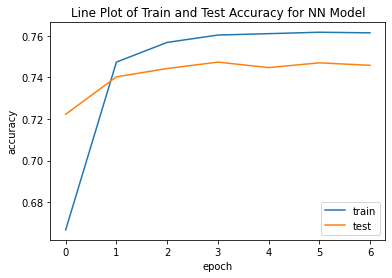

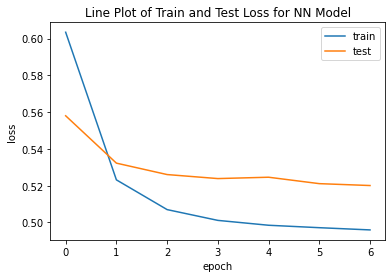

In [ ]:
# Plot accuracy and loss by epoch based on neural network model

plt.plot(MLP_model_history.history['accuracy'])
plt.plot(MLP_model_history.history['val_accuracy'])
plt.title("Line Plot of Train and Test Accuracy for NN Model")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(MLP_model_history.history['loss'])
plt.plot(MLP_model_history.history['val_loss'])
plt.title("Line Plot of Train and Test Loss for NN Model")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Doc2vec with PV-DBOW + Prediction Models

## Doc2Vec (PV-DBOW) representaive

- dm: Decides which algorithm out of PV-DM and PV-DBOW. By default dm=1 (PV-DM) and if dm=0 then PV-DBOW.
- vector_size: Dimensionality of the feature vectors.
- window: The maximum distance between the current and predicted word within a sentence.

In [ ]:
# Tagged documents for train set and test set
train_tagged = tag_docs(train_data, 'token_words')
test_tagged = tag_docs(test_data, 'token_words')

In [ ]:
train_tagged

69597    ([parent, say, first, thing, get, job, case, g...
29120    ([new, generation, home, video, game, go, deve...
65049    ([see, major, magazine, blog, publish, another...
65901    ([self, style, film, critic, Kamaal, Khan, Sun...
29099    ([Japan, Agency, Cultural, Affairs, announce, ...
                               ...                        
50057    ([search, one, physician, make, appointment, f...
98047    ([Senate, floor, clear, lunch, Wednesday, vote...
5192     ([little, know, black, box, information, find,...
77708    ([friend, say, Ibrahim, Abukar, charisma, busi...
98539    ([new, non, traditional, way, buy, property, a...
Length: 79986, dtype: object

In [ ]:
# Build Doc2Vec model (PV-DBOW)
model_0 = train_doc2vec_model(train_tagged, dm = 0, window = 2,  size = 5)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [ ]:
# Building the final vector feature for the classifier
y_train_0, X_train_0 = vec_for_learning(model_0, train_tagged)
y_test_0, X_test_0 = vec_for_learning(model_0, test_tagged)

In [ ]:
print(model_0.docvecs.count) # should be 2 since there are 2 classes (or two tages)

2


In [ ]:
X_train_0[0:10]

(array([ 1.925918  ,  0.7759757 ,  0.12940107, -1.0082606 ,  0.19140133],
       dtype=float32),
 array([ 0.969189  , -0.65579414,  0.41233325, -2.4013264 , -0.02237831],
       dtype=float32),
 array([ 1.058638  , -0.39141956,  0.16702782, -0.8613876 , -1.4222398 ],
       dtype=float32),
 array([ 2.3263268 ,  1.5848604 ,  1.5211195 , -0.26507896, -0.9226023 ],
       dtype=float32),
 array([ 1.4091927 ,  0.69139886,  0.5499346 , -0.8470656 , -0.3769294 ],
       dtype=float32),
 array([ 0.0442069 , -0.6354605 ,  0.46347395, -1.4305538 , -2.2122145 ],
       dtype=float32),
 array([-0.49827495, -0.36855358, -0.09427674, -2.060857  , -1.7136256 ],
       dtype=float32),
 array([-0.6478742 ,  1.9119451 , -0.63514596, -1.7746365 , -1.0134162 ],
       dtype=float32),
 array([ 0.8312233 ,  2.5328648 , -0.87192494,  0.532183  , -2.27086   ],
       dtype=float32),
 array([ 0.7143129 , -1.4048384 , -3.8878899 , -0.41584682, -2.402537  ],
       dtype=float32))

In [ ]:
y_train_0[0:10]

(0, 0, 1, 1, 1, 1, 0, 0, 1, 0)

In [ ]:
print(len(model_0.wv.vocab))
model_0.wv.vocab

85571


{'parent': <gensim.models.keyedvectors.Vocab at 0x7feb338e5e80>,
 'say': <gensim.models.keyedvectors.Vocab at 0x7feb2d16c128>,
 'first': <gensim.models.keyedvectors.Vocab at 0x7feb2d16c160>,
 'thing': <gensim.models.keyedvectors.Vocab at 0x7feb2d16c1d0>,
 'get': <gensim.models.keyedvectors.Vocab at 0x7feb2d16c208>,
 'job': <gensim.models.keyedvectors.Vocab at 0x7feb2d16c240>,
 'case': <gensim.models.keyedvectors.Vocab at 0x7feb2d16c0b8>,
 'restaurant': <gensim.models.keyedvectors.Vocab at 0x7feb2d16c048>,
 'grow': <gensim.models.keyedvectors.Vocab at 0x7feb2d16c080>,
 'father': <gensim.models.keyedvectors.Vocab at 0x7feb2d16c278>,
 'shave': <gensim.models.keyedvectors.Vocab at 0x7feb2d16c2b0>,
 'one': <gensim.models.keyedvectors.Vocab at 0x7feb2d16c2e8>,
 'show': <gensim.models.keyedvectors.Vocab at 0x7feb2d16c320>,
 'cast': <gensim.models.keyedvectors.Vocab at 0x7feb2d16c358>,
 'member': <gensim.models.keyedvectors.Vocab at 0x7feb2d16c390>,
 'go': <gensim.models.keyedvectors.Vocab at 

## Decision Tree Model

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=50)

# Train Decision Tree Classifer
clf = clf.fit(X_train_0,y_train_0)

# Predict the response for test dataset
y_pred_0 = clf.predict(X_test_0)

DT_accuracy_0 = accuracy_score(y_test_0, y_pred_0)
DT_f1_score_0 = f1_score(y_test_0, y_pred_0, average="weighted")
DT_precision_0 = precision_score(y_test_0, y_pred_0, average="weighted")
DT_recall_0 = recall_score(y_test_0, y_pred_0, average="weighted")

# print("Decision Tree: ")
print(confusion_matrix(y_test_0, y_pred_0))

# accuracy, f1, precision, recall
print("Accuracy: ", accuracy_score(y_test_0, y_pred_0))
print("F1 score: ", f1_score(y_test_0, y_pred_0, average="weighted"))
print("Precision: ", precision_score(y_test_0, y_pred_0, average="weighted"))
print("Recall: ", recall_score(y_test_0, y_pred_0, average="weighted"))

[[7306 2608]
 [2373 7710]]
Accuracy:  0.7509126368955343
F1 score:  0.7508534741216222
Precision:  0.7510018587185308
Recall:  0.7509126368955343


## Neural Network Model

In [ ]:
# Convert tuple of array to array of array
X_train_0_r = np.asarray(X_train_0)
X_test_0_r = np.asarray(X_test_0)

n_cols = X_train_0_r.shape[1]
num_classes = 2
  
# One-hot encoding for target y
Y_train_0 = np_utils.to_categorical(y_train_0, num_classes)
Y_test_0 = np_utils.to_categorical(y_test_0, num_classes)

MLP_model_0 = Sequential()

MLP_model_0.add(Dense(512, input_shape=(n_cols,), kernel_initializer='uniform',activation='relu'))
MLP_model_0.add(Dense(512, kernel_initializer='uniform', activation='relu'))
MLP_model_0.add(Dense(num_classes, kernel_initializer='uniform',activation='sigmoid'))

MLP_model_0.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam') 

## Optimize MLP's parameters
opt = RMSprop(lr=0.0001, decay=1e-6)
MLP_model_0.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

#MLP_model_history = MLP_model_0.fit(X_train_r, Y_train, batch_size=50, epochs=10, verbose=None,
                      #validation_data=(X_test_r, Y_test))

# Early stop the MLP model
early_stopping_monitor = EarlyStopping(monitor='val_accuracy', mode='max', patience=3)
MLP_model_history_0 = MLP_model_0.fit(X_train_0_r, Y_train_0, batch_size=100, epochs=30, verbose=2,
                            validation_data=(X_test_0_r, Y_test_0), callbacks=[early_stopping_monitor])
  

y_pred_0 = MLP_model_0.predict_classes(X_test_0_r, batch_size=32)

NN_accuracy_0 = accuracy_score(y_test_0, y_pred_0)
NN_f1_score_0 = f1_score(y_test_0, y_pred_0, average="weighted")
NN_precision_0 = precision_score(y_test_0, y_pred_0, average="weighted")
NN_recall_0 = recall_score(y_test_0, y_pred_0, average="weighted")

print(confusion_matrix(y_test_0, y_pred_0))

# accuracy, f1, precision, recall
print("Accuracy: ", accuracy_score(y_test_0, y_pred_0))
print("F1 score: ", f1_score(y_test_0, y_pred_0, average="weighted"))
print("Precision: ", precision_score(y_test_0, y_pred_0, average="weighted"))
print("Recall: ", recall_score(y_test_0, y_pred_0, average="weighted"))

Epoch 1/30
800/800 - 11s - loss: 0.4082 - accuracy: 0.8277 - val_loss: 0.4765 - val_accuracy: 0.7811
Epoch 2/30
800/800 - 11s - loss: 0.3748 - accuracy: 0.8315 - val_loss: 0.4757 - val_accuracy: 0.7816
Epoch 3/30
800/800 - 11s - loss: 0.3733 - accuracy: 0.8316 - val_loss: 0.4770 - val_accuracy: 0.7806
Epoch 4/30
800/800 - 11s - loss: 0.3725 - accuracy: 0.8328 - val_loss: 0.4740 - val_accuracy: 0.7817
Epoch 5/30
800/800 - 11s - loss: 0.3714 - accuracy: 0.8331 - val_loss: 0.4746 - val_accuracy: 0.7836
Epoch 6/30
800/800 - 10s - loss: 0.3711 - accuracy: 0.8330 - val_loss: 0.4711 - val_accuracy: 0.7840
Epoch 7/30
800/800 - 11s - loss: 0.3705 - accuracy: 0.8332 - val_loss: 0.4728 - val_accuracy: 0.7843
Epoch 8/30
800/800 - 11s - loss: 0.3699 - accuracy: 0.8345 - val_loss: 0.4753 - val_accuracy: 0.7811
Epoch 9/30
800/800 - 11s - loss: 0.3696 - accuracy: 0.8340 - val_loss: 0.4712 - val_accuracy: 0.7849
Epoch 10/30
800/800 - 11s - loss: 0.3693 - accuracy: 0.8344 - val_loss: 0.4727 - val_accura

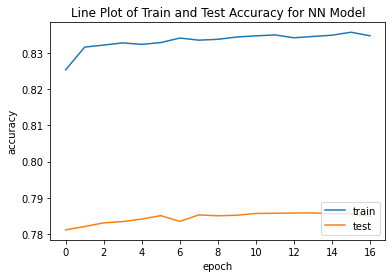

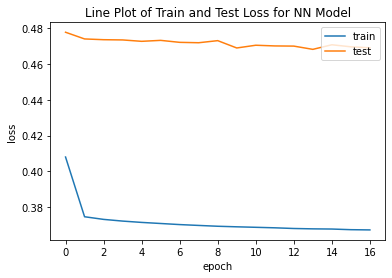

In [ ]:
# Plot accuracy and loss by epoch based on neural network model

#plt.figure(figsize = (5,3))
plt.plot(MLP_model_history_0.history['accuracy'])
plt.plot(MLP_model_history_0.history['val_accuracy'])
plt.title("Line Plot of Train and Test Accuracy for NN Model")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(MLP_model_history_0.history['loss'])
plt.plot(MLP_model_history_0.history['val_loss'])
plt.title("Line Plot of Train and Test Loss for NN Model")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Results

## Summary table

In [ ]:
# Create a report table for DV-DM
report_table_1 = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-score', 'Precision', 'Recall'])

# Adding scores into report table 
report_table_1 = report_table_1.append({'Model' : 'Decision Tree',
                                  'Accuracy': DT_accuracy_1,'F1-score': DT_f1_score_1,
                                  'Precision': DT_precision_1,'Recall' : DT_recall_1}, 
                                  ignore_index=True)

report_table_1 = report_table_1.append({'Model' : 'Neural Network',
                                  'Accuracy': NN_accuracy_1,'F1-score': NN_f1_score_1,
                                  'Precision': NN_precision_1,'Recall' : NN_recall_1}, 
                                  ignore_index=True)
print("Report table for DV-DM:")
report_table_1

Report table for DV-DM:


,Model,Accuracy,F1-score,Precision,Recall
0,Decision Tree,0.696705,0.696599,0.696802,0.696705
1,Neural Network,0.745862,0.745702,0.746214,0.745862


In [ ]:
# Create a report table for DP-DBOW
report_table_0 = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-score', 'Precision', 'Recall'])

# Adding scores into report table 
report_table_0 = report_table_0.append({'Model' : 'Decision Tree',
                                  'Accuracy': DT_accuracy_0,'F1-score': DT_f1_score_0,
                                  'Precision': DT_precision_0,'Recall' : DT_recall_0}, 
                                  ignore_index=True)

report_table_0 = report_table_0.append({'Model' : 'Neural Network',
                                  'Accuracy': NN_accuracy_0,'F1-score': NN_f1_score_0,
                                  'Precision': NN_precision_0,'Recall' : NN_recall_0}, 
                                  ignore_index=True)
print("Report table for DP-DBOW:")
report_table_0

Report table for DP-DBOW:


,Model,Accuracy,F1-score,Precision,Recall
0,Decision Tree,0.750913,0.750853,0.751002,0.750913
1,Neural Network,0.783067,0.782388,0.785953,0.783067


In [ ]:
# Create a report table for DV-DM (dm=1) and DV-DBOW (dm=0)
report_table = pd.DataFrame(columns=['Doc2Vec Type', 'Model', 'Accuracy', 'F1-score', 'Precision', 'Recall'])

# Adding scores into report table
report_table = report_table.append({'Doc2Vec Type': 'DV-DM',
                                    'Model' : 'Decision Tree',
                                    'Accuracy': DT_accuracy_1,'F1-score': DT_f1_score_1,
                                    'Precision': DT_precision_1,'Recall' : DT_recall_1}, 
                                   ignore_index=True)

report_table = report_table.append({'Doc2Vec Type': 'DV-DM',
                                    'Model' : 'Neural Network',
                                    'Accuracy': NN_accuracy_1,'F1-score': NN_f1_score_1,
                                    'Precision': NN_precision_1,'Recall' : NN_recall_1},
                                   ignore_index=True)

report_table = report_table.append({'Doc2Vec Type': 'DV-DBOW',
                                    'Model' : 'Decision Tree',
                                    'Accuracy': DT_accuracy_0,'F1-score': DT_f1_score_0,
                                    'Precision': DT_precision_0,'Recall' : DT_recall_0},
                                   ignore_index=True)

report_table = report_table.append({'Doc2Vec Type': 'DV-DBOW',
                                    'Model' : 'Neural Network',
                                    'Accuracy': NN_accuracy_0,'F1-score': NN_f1_score_0,
                                    'Precision': NN_precision_0,'Recall' : NN_recall_0},
                                    ignore_index=True)
print("Report table:")
report_table

Report table:


,Doc2Vec Type,Model,Accuracy,F1-score,Precision,Recall
0,DV-DM,Decision Tree,0.696705,0.696599,0.696802,0.696705
1,DV-DM,Neural Network,0.745862,0.745702,0.746214,0.745862
2,DV-DBOW,Decision Tree,0.750913,0.750853,0.751002,0.750913
3,DV-DBOW,Neural Network,0.783067,0.782388,0.785953,0.783067


## Plots

In [ ]:
# Create a report table for PV-DM
report_table_11 = pd.DataFrame(columns = ['Scores', 'Decision Tree', 'Neural Network'])

report_table_11['Scores'] = ['Accuracy', 'F1-score', 'Precision', 'Recall']
report_table_11['Decision Tree'] = [DT_accuracy_1, DT_f1_score_1, DT_precision_1, DT_recall_1]
report_table_11['Neural Network'] = [NN_accuracy_1, NN_f1_score_1, NN_precision_1, NN_recall_1]

report_table_11

,Scores,Decision Tree,Neural Network
0,Accuracy,0.696705,0.745862
1,F1-score,0.696599,0.745702
2,Precision,0.696802,0.746214
3,Recall,0.696705,0.745862


Text(0.5, 0, 'Type of scores')

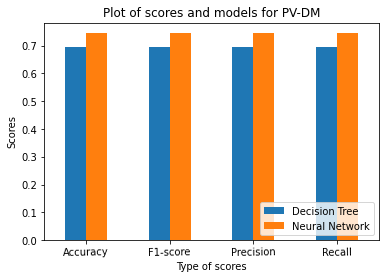

In [ ]:
models = ['Decision Tree', 'Neural Network']

report_table_11.plot(x="Scores", y=models, kind="bar", rot = 1)
plt.legend(loc='lower right')
plt.title("Plot of scores and models for PV-DM")
plt.ylabel("Scores")
plt.xlabel("Type of scores")

In [ ]:
# Create a report table for PV-DBOW
report_table_00 = pd.DataFrame(columns = ['Scores', 'Decision Tree', 'Neural Network'])

report_table_00['Scores'] = ['Accuracy', 'F1-score', 'Precision', 'Recall']
report_table_00['Decision Tree'] = [DT_accuracy_0, DT_f1_score_0, DT_precision_0, DT_recall_0]
report_table_00['Neural Network'] = [NN_accuracy_0, NN_f1_score_0, NN_precision_0, NN_recall_0]

report_table_00

,Scores,Decision Tree,Neural Network
0,Accuracy,0.750913,0.783067
1,F1-score,0.750853,0.782388
2,Precision,0.751002,0.785953
3,Recall,0.750913,0.783067


Text(0.5, 0, 'Type of scores')

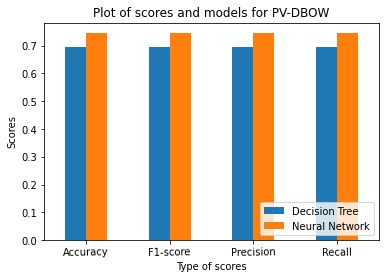

In [ ]:
models = ['Decision Tree', 'Neural Network']

report_table_11.plot(x="Scores", y=models, kind="bar", rot = 1)
plt.legend(loc='lower right')
plt.title("Plot of scores and models for PV-DBOW")
plt.ylabel("Scores")
plt.xlabel("Type of scores")

In [ ]:
# Create a report table for PV-DM (dm=1) and PV-DBOW (dm=0)
report_table_ = pd.DataFrame(columns = ['Scores', 'PV-DM / DecisionTree', 'PV-DM / NeuralNetwork',
                                        'PV-DBOW / DecisionTree','PV-DBOW / NeuralNetwork'])

report_table_['Scores'] = ['Accuracy', 'F1-score', 'Precision', 'Recall']
report_table_['PV-DM / DecisionTree'] = [DT_accuracy_1, DT_f1_score_1, DT_precision_1, DT_recall_1]
report_table_['PV-DM / NeuralNetwork'] = [NN_accuracy_1, NN_f1_score_1, NN_precision_1, NN_recall_1]
report_table_['PV-DBOW / DecisionTree'] = [DT_accuracy_0, DT_f1_score_0, DT_precision_0, DT_recall_0]
report_table_['PV-DBOW / NeuralNetwork'] = [NN_accuracy_0, NN_f1_score_0, NN_precision_0, NN_recall_0]

report_table_

,Scores,PV-DM / DecisionTree,PV-DM / NeuralNetwork,PV-DBOW / DecisionTree,PV-DBOW / NeuralNetwork
0,Accuracy,0.696705,0.745862,0.750913,0.783067
1,F1-score,0.696599,0.745702,0.750853,0.782388
2,Precision,0.696802,0.746214,0.751002,0.785953
3,Recall,0.696705,0.745862,0.750913,0.783067


Text(0.5, 0, 'Type of scores')

<Figure size 1080x720 with 0 Axes>

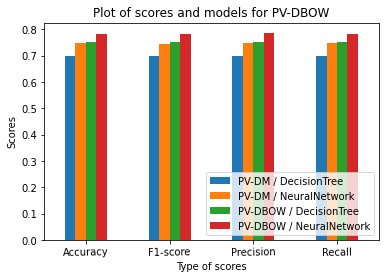

In [ ]:
models = ['PV-DM / DecisionTree', 'PV-DM / NeuralNetwork', 'PV-DBOW / DecisionTree','PV-DBOW / NeuralNetwork']

#plt.figure(figsize = (15,10))
report_table_.plot(x="Scores", y=models, kind="bar", rot = 1)
plt.legend(loc='lower right')
plt.title("Plot of scores and models for PV-DBOW")
plt.ylabel("Scores")
plt.xlabel("Type of scores")

# Detecting data problems which may impact models' performance

## Language detection

Check to see whether there are any non-English texts in the data.

In [ ]:
# Determine texts' language
# ref: https://stackoverflow.com/questions/39142778/python-how-to-determine-the-language
DetectorFactory.seed = 0
cols = ['length', 'text', 'tidy_text', 'label']
df_lang = df[cols].copy()

lower_text = df_lang['text'].apply(str.lower)
df_lang['language'] = lower_text.apply(detect)
df_lang.head()

,length,text,tidy_text,label,language
0,1017,What happens if you try to get a gun without a...,happen try get gun without background check tu...,GPT-2,en
1,90,"""Jim: On Kenya, your person in the field might...",Jim Kenya person field may look impact Obama p...,real,en
2,155,The latest offering from Corporate Watch is no...,late offering Corporate Watch available buy Fr...,real,en
3,411,Mumbai has one of the largest number of migran...,Mumbai one large number migrant India accord U...,real,en
4,87,Make sure to check out the Tournament Informat...,make sure check Tournament Information rule ev...,real,en


In [ ]:
print("Unique languages in the dataset: ", df_lang['language'].unique())

Unique languages in the dataset:  ['en' 'ja' 'fr' 'ca' 'sv' 'it' 'pl' 'so' 'ko' 'nl' 'hu' 'no' 'de' 'sw'
 'es' 'fi' 'et' 'af' 'cy' 'pt' 'ro']


In [ ]:
print("Percentage of English language: ", sum(df_lang['language'] == "en")/ df_lang.shape[0] * 100)
print("Count number of different languages in the dataset: ")
vc = df_lang['language'].value_counts()
df_lang_sum = pd.DataFrame(vc)
df_lang_sum.T

Percentage of English language:  99.94098996829462
Count number of different languages in the dataset: 


,en,ca,fr,it,ja,sv,pl,no,es,fi,nl,et,de,pt,so,sw,hu,cy,ko,af,ro
language,99924,13,8,5,5,5,3,3,3,2,2,1,1,1,1,1,1,1,1,1,1


In [ ]:

df_lang[df_lang['language'] != "en"]

,length,text,tidy_text,label,language
2794,1024,Stats Growth Chart HP: Normal ATK: Normal RCV:...,Stats Growth Chart HP normal atk normal RCV No...,real,ja
3412,1024,"""\n\n"" , [ 200 ]. join ([ "" http://www.bogusga...",join join merge join return false return true ...,GPT-2,fr
3914,300,vue-svg-loader\n\nwebpack loader that lets you...,vue svg loader webpack loader let use SVG file...,real,fr
6126,1024,4/17/18 1 square = 515\n\n4/16/18 2 squares = ...,square square square square square square squa...,real,ca
6710,1024,"1536K thread a guest Dec 1st, 2016 60 Never a ...",thread guest Dec st never guest never member P...,real,sv
7105,814,The following tables list the most commonly us...,follow table list commonly use letter Japanese...,GPT-2,ja
7671,893,"Tired of the typical ""You can still get it on ...",tired typical still get Amazon com marketing m...,GPT-2,it
7675,1024,Still loading...\n\nA B C D E F G H I J K L M ...,still load rank City State estimate Census Cha...,real,pl
7858,1024,Still loading...\n\nA B C D E F G H I J K L M ...,still load ID Quiz Nagel Quiz Jackson Quiz cha...,real,ca
10614,537,1\n\n2\n\n3\n\n4\n\n5\n\n6\n\n7\n\n$ /month $ ...,month day day hour hour day hour day hour day ...,GPT-2,so


In [ ]:

df_lang.loc[[18473, 18474, 27765,32013, 39727, 35591, 55021,79228]]

,length,text,tidy_text,label,language
18473,1024,"즐거움이 가득한 보물창고, 티빙!\n\n\n1. 가장 트렌디한 예능과 기대작을 만나...",tvN Mnet ocn JTBC MBN CJ ENM pick Clips TV LTE...,real,ko
18474,1024,Het is altijd makkelijk als je even geen tijd ...,Het altijd makkelijk als je even geen tijd heb...,real,nl
27765,119,"Sociology 621, Class, State and Ideology Fall ...",sociology Class State Ideology Fall Jacques Bi...,real,fr
32013,93,"Tiêu đề\n\n""The mask of command"": Bernard L. M...",Ti mask command Bernard Montgomery George Patt...,real,de
39727,1024,You have searched for packages that names cont...,search package name contain viper suite sectio...,GPT-2,ca
35591,432,New at SubtleTV! Close\n\nVideo: Video: NWA - ...,new subtletv close video video NWA like girl W...,GPT-2,no
55021,216,Régine Café\n\nRégine c'est la « matante » idé...,gine Caf gine est la matante id ale que nous a...,real,fr
79228,11,1 2 3 4 5 6 7 8 9 NEXT All,NEXT,GPT-2,ca


In [ ]:
df_lang['text'][18473]

'즐거움이 가득한 보물창고, 티빙!\n\n\n1. 가장 트렌디한 예능과 기대작을 만나세요!\n\ntvN, Mnet, OCN, JTBC, MBN 등 CJ ENM과 종편 실시간 방송을 무료로 시청하세요.\n\n\n2.#연애플레이리스트 #전지적 짝사랑 시점 #핑크퐁\n\n핫한 웹드, 웹예능, 키즈 애니메이션까지 모두 티빙에서 즐기세요.\n\n\n3. 취향대로 골라보는 클립! 픽클(Pick Clips)을 통해\n\n당신의 시간을 더 즐겁게 만들어 보세요.\n\n\n4. TV화면에서도 만나는 티빙!\n\n크롬캐스트 지원, 큰 화면으로도 콘텐츠를 만나보세요.\n\n\n[앱 접근 권한 동의 규정 안내]\n\n\n2017년 3월 23일 시행되는 정보통신망법 제 22조의 2(접근권한에 대한 동의)의 규정에 맞추어 서비스에 꼭 필요한 항목만을 필수접근하고 있으며, 그 내용은 아래와 같습니다.\n\n\n[필수 접근 권한]\n\n\n네트워크 연결\n\n- LTE/Wifi 연결 및 MACAddress/IPAddress 정보를 위한 접근\n\n시스템 설정\n\n- 영상 음량 및 통화 상태 체크를 위한 접근\n\nDevice ID\n\n- 푸시 알림 및 통화 상태 체크를 위한 접근\n\n앱 종료\n\n- 앱 업데이트를 위한 접근\n\n절전 모드 전�'

In [ ]:
df_lang['text'][55021]

"Régine Café\n\nRégine c'est la « matante » idéale que nous avons imaginée. Celle qui vous accueille à bras ouverts, vous traite aux petits oignons, vous conforte et ne vous laisse jamais partir le ventre vide. Pour vous chouchouter, nous préparons tout sur place, des brioches à la cannelle, jambon cuit sur l'os, fèves au lard, aucun compromis sur la qualité.\n\nTante Régine is an imaginary persona inspired by the ideal of a loving, doting aunt who always embraces you with open arms and, above all, never lets you leave with an empty stomach. To spoil and pamper you, everything is prepared on the premises—the cinnamon buns, scones, ham on the bone, baked beans—you name it. And we never compromise on quality."

In [ ]:
df_lang['text'][41469]

'HANOI — One year after its launch, the Vietnam People\'s Volunteer Corps (VVPV) is set to take to the field in a bid to rebuild the nation\'s military after decades of neglect.\n\nThe Corps will train 10,000 people to serve as soldiers and police officers, and help train an additional 60,000 soldiers, according to VVPV Chief Commander Col. Nguyen Van Do.\n\nOn Thursday, President Tran Dai Quang signed the decree for the Vietnam People\'s Volunteer Corps (VVPV) at the Vietnam War Veterans Memorial in Hanoi.\n\nThe Corps, founded in 2014, is comprised of volunteers from all over the country. It is believed to be the first Vietnam-based national army created by foreign forces.\n\nAccording to VVPV spokesman Col. Nguyen Xuan Phan, the Corps began training more than 200 VVPV volunteers in January 2015. The Corps received its first recruits two months later, and now employs about 50,000 active volunteers.\n\n"I wish the Corps would stay for another one year and complete the training of 2 mi

In [ ]:
df_lang['text'][87527]

'[size=18mb]\n\n[size=16mb][/size]\n\n[size=8mb][/size]\n\n[size=8mb][/size]\n\n[size=8mb][/size]\n\n[size=7.4mb][/size]\n\n[size=7.4mb][/size]\n\n[size=4.8mb][/size]\n\n[size=4.8mb][/size]\n\n[size=3.9mb][/size]\n\n[size=3.3mb][/size]\n\n[size=2.9mb][/size]\n\n[size=2.9mb][/size]\n\n[size=2.8mb][/size]\n\n[size=2.3mb][/size]\n\n[size=2.1mb][/size]\n\n[size=1.4mb][/size]\n\n[size=1.4mb][/size]\n\n[size=1.3mb][/size]\n\n[size=1.2mb][/size]\n\n[size=1.1mb][/size]\n\n[size=0.7mb][/size]\n\n[size=0.7mb][/size]\n\n[size=0.6mb][/size]\n\n[size=0.6mb][/size]\n\n[size=0.6mb][/size]\n\n[size=0.6mb][/size]\n\n[size=0.6mb][/size]\n\n[size=0.9mb][/size]\n\n[size=0.8mb][/size]\n\n[size=0.8mb][/size]\n\n[size=0.8mb][/size]\n\n[size=0.8mb][/size]\n\n[size=0.8mb][/size]\n\n[size=0.8mb][/size]\n\n[size=0.6mb][/size]\n\n[size=0.5mb][/size]\n\n[size=0.5mb][/size]\n\n[size=0.3mb][/size]\n\n[size=0.3mb][/size]\n\n[size=0.2mb][/size]\n\n[size=0.1mb][/size]\n\n[size=0.1mb][/size]\n\n[size=0.1mb][/size]\n\n[s

In [ ]:
df_lang['text'][35664]

"I got the gift yesterday. First thing, it's amazing. I didn't even realize what it was till my boyfriend went through the packages. It's the biggest plushie, and he's just as stunned about it as I am, because it's so amazing! But the best part is the note. I'll get to the note later. Anyway, I didn't even get to open the card, and it was amazing. It was very emotional, but it was also in a way reassuring, because, he was saying, that my Secret Santa is so awesome, and that this is a very thoughtful gift. He told me that I've given my all for my secret Santa. They must have liked my blog too. It's really touching.\n\nI opened it up, and it's got a picture of my dog, and a little bit of information, which is how to contact me, what kind of dog, and if it has a personality. It even had a paw print, which I found very comforting and made me feel so much better.\n\nI also pulled out a card, telling me how it had been shipped from my Secret Santa's house, and how his wife was going to surpr